# Summarizing a  text (That does not fit in LLM)

## First Method  "Recursive Summaries" Method
The "Recursive Summaries" method is an effective approach to condense a  text that exceeds the context window (max_tokens) of a Language Learning Model (LLM), such as gpt-3.5-turbo-0125, which has a limit of 16,385 tokens. This method involves dividing the text into manageable chunks, summarizing each chunk, and then summarizing the summaries to create a concise and coherent summary of the original text.

### Step 1: Splitting the Text:
The first step in the "Recursive Summaries" method is to split the  text into smaller chunks. Each chunk should have a size to fit within the token limit of your LLM. For instance, in our case (gpt-3.5-turbo-0125 the max number of tokens is 16,385 tokens, so the input text and the summary should not exceed this token limit). It would be a good idea to take 16,385 – N tokens as input, and keep as maximum N tokens for output. N can be specified according to the size of text, if the text is too , should take into consideration that N * nb of chunks should not pass the LLM context size. A good approach is to calculate N in this step to ensure that the LLM can process each chunk effectively without exceeding its token limit. For example if the initial text is 1M tokens, and each chunck is 15000 tokens, the number of chunks will be 67. We must be sure that 67 * N is less than the context size. 

### Step 2: Summarizing Each Chunk:
Once the text has been divided into manageable chunks, the next step is to create a summary for each chunk. This can be done by feeding each chunk into the LLM and asking it to generate a summary. The LLM will process each chunk and produce a summary that captures the main points and ideas of the chunk. This step ensures that the most important information from each chunk is retained. (You can set a limit for the LLM to not exceed a certain number of words for each summary)
Step 3: Grouping the Summaries:
After summarizing each chunk, the next step is to group all the summaries together. This creates a new text that is composed entirely of the summaries of the original chunks. This new text is typically much shorter than the original text, but it still contains all the main points and ideas.

### Step 4: Summarizing the Summaries:
The final step in the "Recursive Summaries" method is to create a summary of the summaries. This can be done by feeding the new text (i.e., the group of summaries) into the LLM and asking it to generate a summary. The LLM will process the new text and produce a summary that captures the main points and ideas of all the summaries. This final summary is a concise and coherent summary of the original  text.

The "Recursive Summaries" method is a powerful tool for summarizing  texts that exceed the token limit of a Language Learning Model. By dividing the text into manageable chunks, summarizing each chunk, grouping the summaries, and summarizing the summaries, this method allows you to create a concise and coherent summary of the original text. This method ensures that the most important information from the original text is retained, even when the text is too  to be processed by the LLM in its entirety. One of the drawbacks of this method is that summary of summaries can loose some information from the original text. 


In [1]:
import os
import time
import requests
import json
import tiktoken
import PyPDF2
from dotenv import load_dotenv

env_path = 'C:\\Users\\user\\Desktop\\My_Files\\Anaconda  Projects\\DevTechPro\\.env'
load_dotenv(dotenv_path=env_path)
OPENAI_API_KEY= os.getenv('OPENAI_API_KEY')
PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')

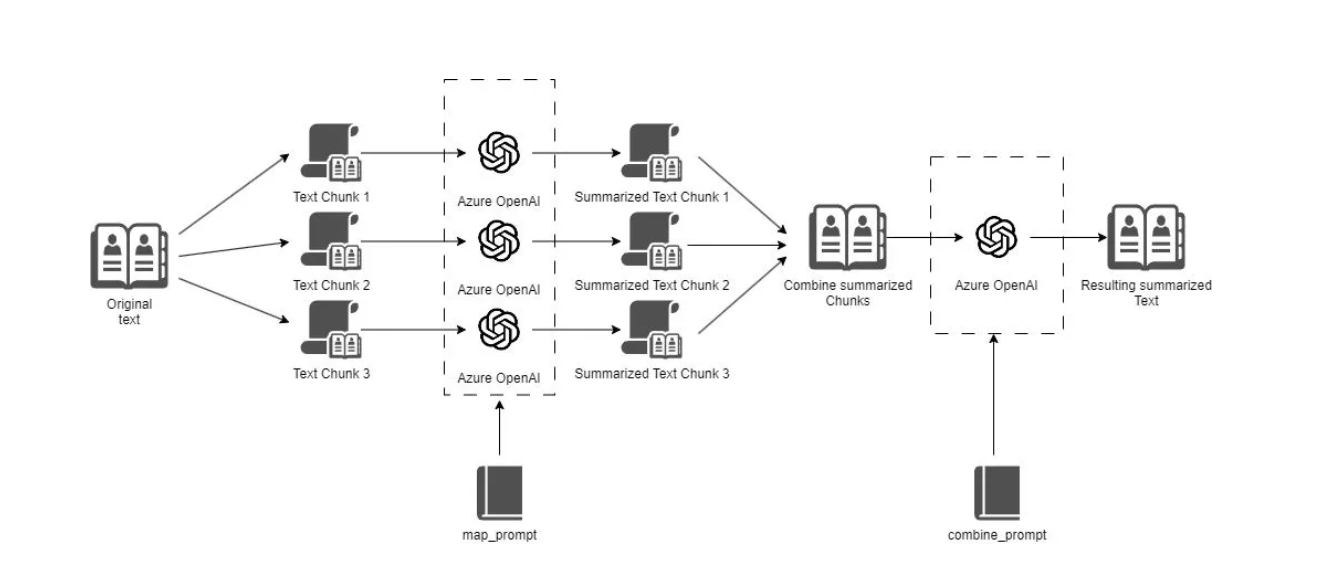

Source: https://bluetickconsultants.medium.com/advanced-techniques-in-text-summarization-leveraging-generative-ai-and-prompt-engineering-fba23f507435

This Python function call_openai serves as an interface to the OpenAI API for generating text-based responses using a specified model. Here's a breakdown of how it works:

- Input Parameters: The function takes several parameters:
- system_prompt: A prompt to provide context or guidance to the model.
- user_prompt: A prompt representing the user's input or query.
- is_json: A boolean indicating whether the response format should be JSON.
- model_name: The name of the model to use (defaults to 'gpt-3.5-turbo-0125').
- temperature: A parameter controlling the randomness of the generated responses.
- max_tokens: The maximum number of tokens (words or subwords) in the generated response.
- max_retries: The maximum number of retry attempts in case of failure.
- backoff_factor: A factor by which the wait time between retries increases.
- openai_api_key: An API key required for authentication with the OpenAI API.
- print_results: A boolean indicating whether to print the response JSON.

Retry Mechanism: The function attempts to call the OpenAI API multiple times (max_retries) in case of failure, with an increasing delay between attempts (backoff_factor). This mechanism helps handle transient errors and network issues.
Building the Request Payload: The function constructs the request payload based on the input parameters, including the model name, prompts, temperature, and maximum tokens. If is_json is True, it includes additional parameters for specifying the response format as JSON.

Sending the Request: Using the requests.post method, the function sends a POST request to the OpenAI API endpoint (https://api.openai.com/v1/chat/completions) with the constructed payload and authentication headers.
Handling the Response: If the response status code is 200 (indicating success), it optionally prints the response JSON (print_results) and returns the response object. Otherwise, it raises an exception indicating a non-200 status code.
Error Handling: In case of any exception during the API call, the function handles it by printing an error message (if print_results is True) and waiting for a certain duration before retrying. The wait duration increases exponentially with each attempt to avoid overwhelming the API.

In [6]:
# # These are many options to split text by characters (Will list them for documentation only)

# #Fixed-size chunking
# from langchain.text_splitter import CharacterTextSplitter
# text_splitter = CharacterTextSplitter(separator = "\n\n",chunk_size = 256,chunk_overlap  = 20)

# # Meaningful chunks with nltk : nltk helps in dividing texts into meanigful chunks
# from langchain.text_splitter import NLTKTextSplitter
# text_splitter = NLTKTextSplitter() 

# # spaCy: spaCy is another powerful Python library for NLP tasks. It offers a sophisticated sentence segmentation feature that can efficiently divide the text into separate sentences, enabling better context preservation in the resulting chunks.
# from langchain.text_splitter import SpacyTextSplitter
# text_splitter = SpacyTextSplitter() 

# # Recursive Chunking
# from langchain.text_splitter import RecursiveCharacterTextSplitter
# text_splitter = RecursiveCharacterTextSplitter(chunk_size = 256,chunk_overlap  = 20)

# # Sfter choosing the best text_splitter, you can pass the the text to text splitter and get the chunks
# # docs = text_splitter.create_documents([text])

If we split a text by number of characters, it is not obvious how many tokens these chunks will be.
And at the same time if we want to split a text into bigger possible chunks and keep these chunks under certain LLM tokens limit, we cannot operate by number of characters.

The better option will be to split by tokens with an overlap so that the chunks will not loose the meaning from previous chunks: 

In [21]:
test = """
Once upon a time, in a faraway kingdom nestled between towering mountains and lush forests, there lived a humble blacksmith named William. He resided in a quaint cottage on the outskirts of the village, where the rhythmic clang of his hammer against the anvil echoed through the serene countryside.

William was not just an ordinary blacksmith; he possessed a rare gift bestowed upon him by the gods themselves. His creations were not mere tools or weapons; they were masterpieces, imbued with magic and infused with the essence of the elements.

One chilly autumn morning, as William was busy forging a new sword for the king's royal guard, a stranger arrived at his doorstep. The stranger was tall and cloaked in a dark hooded robe that concealed his features. He spoke in a deep, melodious voice that sent shivers down William's spine.

"I've heard tales of your craftsmanship, blacksmith," the stranger said, his voice carrying an air of mystery. "I seek a weapon of great power, one that can vanquish even the mightiest of foes. Can you help me?"

William hesitated, sensing an aura of darkness surrounding the stranger. But his curiosity got the better of him, and he agreed to forge the weapon the stranger desired.

For days and nights, William toiled tirelessly in his forge, pouring his heart and soul into crafting the most exquisite weapon he had ever made. He forged it from the rarest metals and enchanted it with ancient runes of protection and destruction.

Finally, after weeks of labor, the weapon was complete. It gleamed in the firelight, its blade shimmering with otherworldly energy. William handed it to the stranger, who nodded in silent approval.

But as the stranger took hold of the weapon, a sinister grin spread across his face. "Thank you, blacksmith," he said, his voice dripping with malice. "With this weapon in my hands, I shall unleash chaos upon the land."

Before William could react, the stranger vanished into thin air, leaving behind only a trail of darkness. Horrified by what he had unwittingly unleashed, William knew he had to set things right.

Arming himself with his trusty hammer and the few weapons he had left, William embarked on a perilous journey to stop the stranger and reclaim the weapon he had forged. Along the way, he encountered fierce monsters, treacherous landscapes, and unlikely allies.

But with courage in his heart and determination in his soul, William pressed on, knowing that the fate of the kingdom rested in his hands. And as he finally confronted the stranger in a climactic showdown atop the highest peak of the mountains, he realized that the true power lay not in the weapon he had forged, but in the strength of his spirit and the purity of his intentions.

In the end, it was not blades or spells that decided the outcome of the battle, but the unyielding will of a humble blacksmith who refused to let darkness triumph over light. And as the sun rose once more over the kingdom, casting its golden rays upon the land, William knew that peace had been restored, and that his journey was finally at an end.

But even as he returned to his forge, ready to resume his life of quiet solitude, William could not help but wonder what other adventures awaited him beyond the horizon. For in a world filled with magic and mystery, anything was possible for those brave enough to dream.

And so, the legend of William the blacksmith lived on, whispered in the winds and sung in the songs of bards, a testament to the power of courage, friendship, and the indomitable human spirit.

The end."""

In [2]:
# Get the tokenization encoder object from tiktoken library
tokenizer = tiktoken.get_encoding("p50k_base")

def read_text_from_pdf(pdf_path):
    text = ""
    try:
        with open(pdf_path, "rb") as file:
            # Create a PDF file reader object
            pdf_reader = PyPDF2.PdfReader(file)
            
            # Iterate through each page of the PDF
            for page_number in range(len(pdf_reader.pages)):
                # Extract text from the page
                page = pdf_reader.pages[page_number]
                text += page.extract_text()
    except Exception as e:
        print(f"Error: {e}")

    return text

def call_openai(system_prompt, user_prompt, is_json=False, model_name='gpt-3.5-turbo-0125', temperature=0.7, max_tokens=600, max_retries=6, backoff_factor=1.5, openai_api_key=OPENAI_API_KEY, print_results=False):
    for attempt in range(max_retries):
        try:
            #https://platform.openai.com/docs/api-reference/chat/create?lang=python
            messages = [{'role': 'system', 'content': system_prompt},
                        {'role': 'user', 'content': user_prompt}]
            url = 'https://api.openai.com/v1/chat/completions'
            if is_json:
                payload = json.dumps({
                    'model': model_name,
                    'messages': messages,
                    'temperature': temperature,
                    'max_tokens': max_tokens,
                    'response_format':{ "type": "json_object" },
            })
            else:
                payload = json.dumps({
                    'model': model_name,
                    'messages': messages,
                    'temperature': temperature,
                    'max_tokens': max_tokens,
            })
            headers = {'Content-Type': 'application/json',
                       'Authorization': f'Bearer {openai_api_key}'}
            response = requests.post(url, data=payload, headers=headers)
            if response.status_code == 200:
                if print_results:
                    print(response.json())
                return response
            else:
                raise Exception('Non-200 response received')
        except Exception as e:
            if print_results:
                print(response.json())
                print(f'Attempt {attempt+1} failed: {e}')
            time.sleep(backoff_factor ** attempt)
       
def split_text(text, max_tokens, chunk_overlap=100): 
    tokenized_text = tokenizer.encode(text)
    chunks = []
    current_chunk = []
    current_length = 0
    overlap = [] 
    
    for token in tokenized_text: 
        current_chunk.append(token)
        current_length += 1 

        if current_length >= max_tokens:
            chunks.append(tokenizer.decode(current_chunk).rstrip(' .,;'))
            overlap = current_chunk[-chunk_overlap:] 
            current_chunk = []
            current_chunk.extend(overlap)
            current_length = len(overlap)

    if current_chunk:
        chunks.append(tokenizer.decode(current_chunk).rstrip(' .,;'))

    return chunks

def summarize_text(text):
    system_prompt = f"""You are a summary expert, Make a summary of the given text with keeping all the important information."""
    user_prompt = f"""Summarize the following text:
    {text}""" #9 tokens
    response = call_openai(system_prompt, user_prompt)
    return response.json()['choices'][0]['message']['content'].strip()

def summarize_chunks(text):
    system_prompt = "You are a summary expert, You will be given many summaries of chunks of a large text , make a summary of these summaries that contain most of the information from chunks. "
    user_prompt = f"""Summarize the following text: 
    {text}""" #9 tokens
    response = call_openai(system_prompt, user_prompt, max_tokens=250, temperature=0.7)
    return response.json()['choices'][0]['message']['content'].strip()

def recursive_summarize(text, max_tokens=16000, chunk_overlap=100):
    #Should take into consideration also the user prompt length
    user_prompt = f"""Summarize the following text:   """ #7 tokens user prompt without text
    max_tokens = max_tokens - len(tokenizer.encode(user_prompt))
    chunks = split_text(text, max_tokens, chunk_overlap=chunk_overlap)

    summaries = [summarize_text(chunk) for chunk in chunks]
    print("Suammaries of Chunks: \n")
    for i,summary in enumerate(summaries):
        print(f"Summary {i}:\n", summary,'\n')
    grouped_summaries = " ".join(summaries)   

    if len(tokenizer.encode(grouped_summaries)) < max_tokens:
        final_summary = summarize_chunks(grouped_summaries)
    else:
        final_summary = recursive_summarize(grouped_summaries)

    return final_summary

In [ ]:
# pdf_path = "Kolmogorov-Arnold Networks.pdf"
pdf_path = "pride and prejudice.pdf"
text = read_text_from_pdf(pdf_path)
summary = recursive_summarize(text)

print("\nFinal Summary: ", summary)

 # With Embeddings

In [3]:
from pinecone import Pinecone, ServerlessSpec
pc = Pinecone(api_key='PINECONE_API_KEY')

In [4]:
index_name = "summarizatoin-index"
pc.create_index(
    name=index_name,
    dimension=1536, # Replace with your model dimensions
    metric="cosine", # Replace with your model metric
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    ) 
)

UnauthorizedException: (401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'X-Cloud-Trace-Context': 'b4532574edb00afaf85c5359fb755376', 'Date': 'Mon, 13 May 2024 06:06:27 GMT', 'Content-Type': 'text/html', 'Server': 'Google Frontend', 'Content-Length': '15', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: Invalid API Key


: 